In [1]:
import pyvista as pv
import os
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
print(pv.Report())


--------------------------------------------------------------------------------
  Date: Wed Nov 13 18:29:43 2024 CET

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 32
           Machine : x86_64
      Architecture : 64bit
               RAM : 62.4 GiB
       Environment : Jupyter
       File system : ext4
        GPU Vendor : Microsoft Corporation
      GPU Renderer : D3D12 (AMD Radeon(TM) Graphics)
       GPU Version : 4.2 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
  MathText Support : True

  Python 3.12.4 (main, Jun  8 2024, 18:29:57) [GCC 11.4.0]

           pyvista : 0.44.1
               vtk : 9.3.1
             numpy : 2.1.3
        matplotlib : 3.9.2
            scooby : 0.10.0
             pooch : 1.8.2
            pillow : 11.0.0
           imageio : 2.36.0
           IPython : 8.29.0
      nest_asyncio : 1.6.0
--------------------------------------------------------------------------------


In [3]:
vtu_files = [f  for f in os.listdir(os.path.join(os.curdir,'results')) if f.endswith('.vtu')]
vtu_files.sort()
print(f'{len(vtu_files)} vtu files found')

100 vtu files found


In [4]:
mesh_t0 = pv.read(os.path.join(os.curdir,'results', vtu_files[0]))

2024-11-13 18:29:43.403 (   1.074s) [    7F55DB1BB000]        vtkRenderer.cxx:1161  WARN| vtkOpenGLRenderer (0x391d0a0): Resetting view-up since view plane normal is parallel
/home/mjfwest/elmerfemtests/elmer-elmag/.venv/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


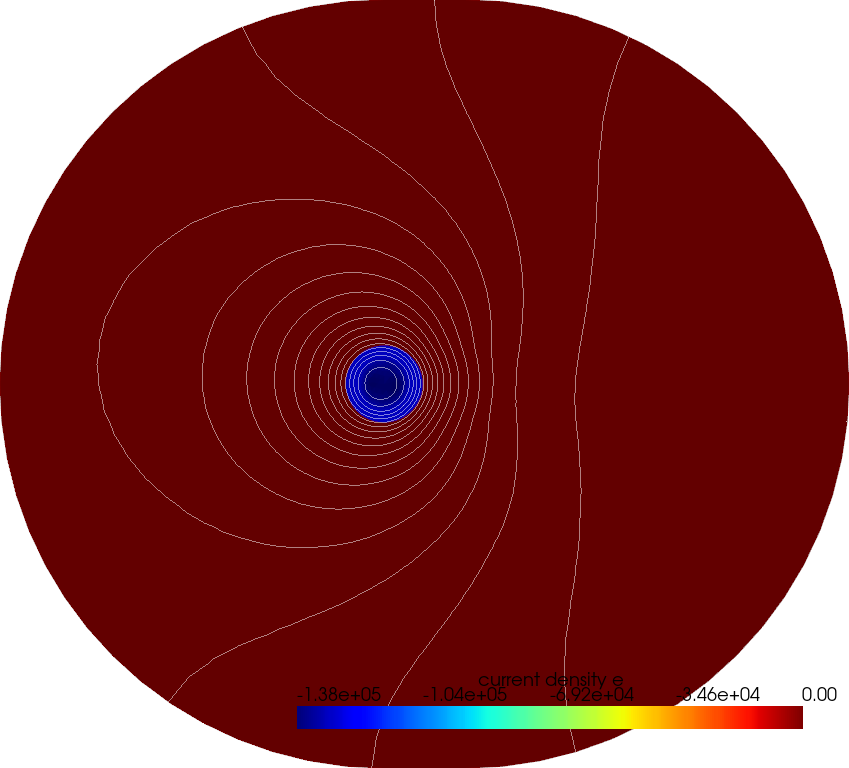

In [5]:
p = pv.Plotter()
p.add_mesh(mesh_t0, scalars="current density e", component=2, show_edges=False, cmap='jet')
p.add_mesh(mesh_t0.contour(isosurfaces=20, scalars='a', method='contour'),color='white',point_size=1, show_edges=False, opacity=0.5)
p.set_viewup([0,0,1])
p.camera.zoom('tight')
p.show()

In [6]:
WIRE_1_ID = 1
WIRE_2_ID = 2

wire_1 = mesh_t0.threshold([WIRE_1_ID - 0.1, WIRE_1_ID + 0.1], scalars="GeometryIds")

/home/mjfwest/elmerfemtests/elmer-elmag/.venv/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


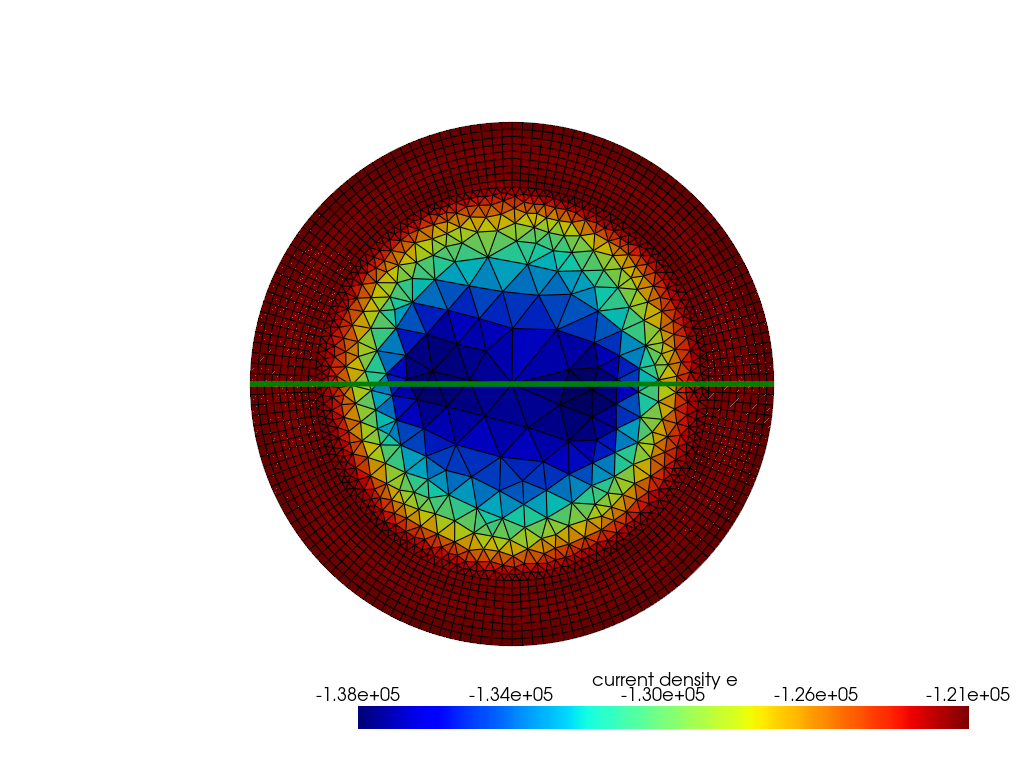

In [7]:
p = pv.Plotter()
p.add_mesh(wire_1, scalars="current density e", component=2, show_edges=True, cmap='jet')
p.set_viewup([0,1,0])

p.add_mesh(pv.Line((-1e-3,0,0), (1e-3,0,0)), color='green', line_width=5)
p.show()

/home/mjfwest/elmerfemtests/elmer-elmag/.venv/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


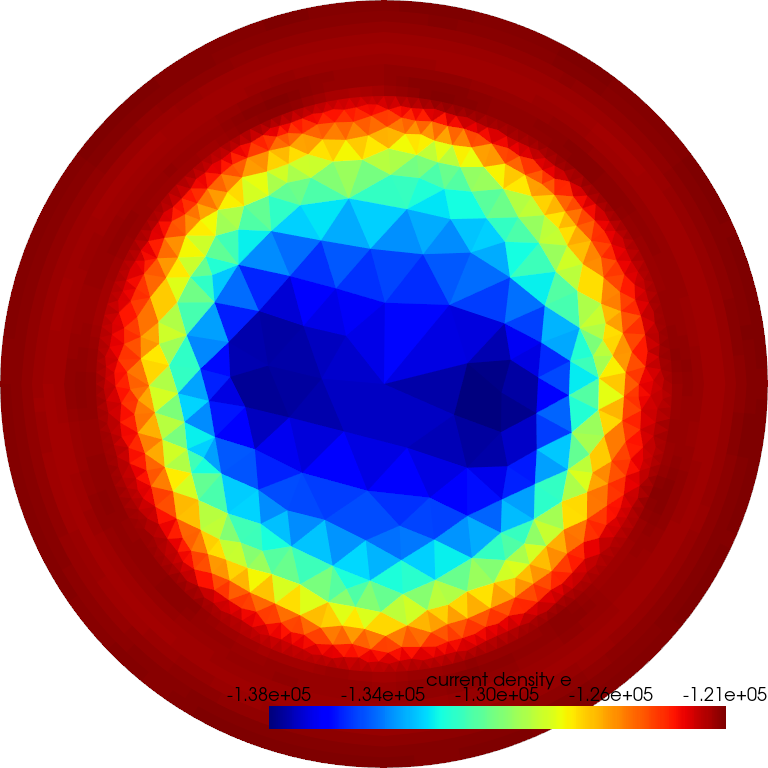

INFO:__main__:Processing s_t0001.vtu
/home/mjfwest/elmerfemtests/elmer-elmag/.venv/lib/python3.12/site-packages/pyvista/plotting/plotter.py:4872: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the points of a mesh in-place instead.
  warnings.warn(
/home/mjfwest/elmerfemtests/elmer-elmag/.venv/lib/python3.12/site-packages/pyvista/plotting/plotter.py:4796: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the scalars of a mesh in-place instead.
  warnings.warn(
INFO:__main__:Processing s_t0002.vtu
INFO:__main__:Processing s_t0003.vtu
INFO:__main__:Processing s_t0004.vtu
INFO:__main__:Processing s_t0005.vtu
INFO:__main__:Processing s_t0006.vtu
INFO:__main__:Processing s_t0007.vtu
INFO:__main__:Processing s_t0008.vtu
INFO:__main__:Processing s_t0009.vtu
INFO:__main__:Processing s_t0010.vtu
INFO:__main__:Processing s_t0011.vtu
INFO:__main__:Proces

In [8]:
RESOLUTION=100
WIRE_DIAMETER = 2e-3

p = pv.Plotter(notebook=True, off_screen=True)
p.open_gif('results/j.gif')

mesh = pv.read(os.path.join(os.curdir,'results', vtu_files[0]))
wire_mesh = mesh.threshold([WIRE_1_ID - 0.1, WIRE_1_ID + 0.1], scalars="GeometryIds")
p.add_mesh(wire_mesh, scalars="current density e", component=2, show_edges=False, cmap='jet', lighting=False)
p.set_viewup([0,1,0])
p.camera.zoom('tight')
p.show()
p.update_scalar_bar_range([-4e5, 4e5])

wire_currrent = np.empty((len(vtu_files), 2))
wire_current_density = np.empty((len(vtu_files), RESOLUTION+1))
wire_positions = np.linspace(-WIRE_DIAMETER/2, WIRE_DIAMETER/2, RESOLUTION+1)

for idx, vtu_file in enumerate(vtu_files):
    logger.info(f'Processing {vtu_file}')
    mesh = pv.read(os.path.join(os.curdir,'results', vtu_file))
    for wire in [WIRE_1_ID, WIRE_2_ID]:
        wire_mesh = mesh.threshold([wire - 0.1, wire + 0.1], scalars="GeometryIds")
        wire_mesh_int = wire_mesh.integrate_data()
        wire_currrent[idx, wire-1] = wire_mesh_int['current density e'][0, 2] # 2 is the z component
        # sample across the wire,
        if wire == WIRE_1_ID:
            p.update_coordinates(wire_mesh.points, render=False)
            p.update_scalars(wire_mesh['current density e'][:,2], render=False)
            p.write_frame()
            line_sample = wire_mesh.sample_over_line((-WIRE_DIAMETER/2,0,0), (WIRE_DIAMETER/2,0,0), resolution=RESOLUTION)
            wire_current_density[idx] = line_sample['current density e'][:,2]

p.close()

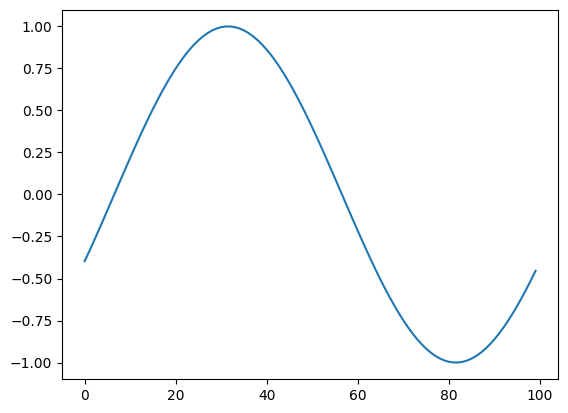

In [9]:
from matplotlib import pyplot as plt
plt.plot(wire_currrent[:,0], label='Wire 1')

In [10]:
np.sqrt(np.mean(wire_currrent**2, axis=0))

array([0.70710053, 0.        ])

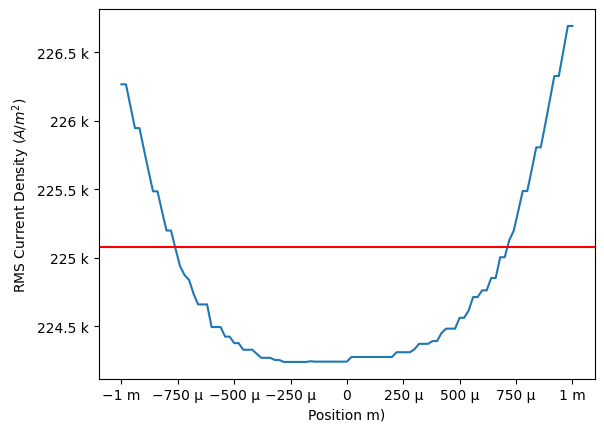

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
#use the enginering tick formatter
from matplotlib.ticker import EngFormatter
ax.yaxis.set_major_formatter(EngFormatter())
ax.xaxis.set_major_formatter(EngFormatter())
ax.plot(wire_positions, np.sqrt(np.mean(wire_current_density**2, axis=0)))
ax.set_xlabel('Position m)')
ax.set_ylabel('RMS Current Density ($A/m^2$)')
rms_dc_current_density = np.sqrt(np.mean(wire_currrent**2, axis=0)) / (np.pi * (WIRE_DIAMETER/2)**2)
ax.axhline(rms_dc_current_density[0], color='red', label='Wire 1 RMS')


In [12]:
import pint
Q = pint.UnitRegistry()
diameter = WIRE_DIAMETER * Q.meter


In [13]:
conductivity = 37e6 * Q.siemens / Q.meter
resistance = 1 / (conductivity * np.pi * diameter**2 / 4)
resistance.to(Q.ohm/Q.meter)

<Quantity(0.0086029699, 'ohm / meter')>

In [14]:
resistance

<Quantity(0.0086029699, '1 / siemens / meter')>